In [2]:
import torch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

sequences = []
for l in open("sequences.txt", 'r').readlines():
    sequences.append(l.strip())
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder()   #n_values=4
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
labels = []
for l in open("labels.txt", 'r').readlines():
    labels.append(l.strip())

one_hot_encoder = OneHotEncoder() #n_values=2
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [6]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

train_features = train_features.transpose((0,2,1))
test_features = test_features.transpose((0,2,1))

In [7]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [10]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv1d(4,32,12),
            nn.MaxPool1d(kernel_size=4),
            Flatten(),
            nn.Linear(288,16),
            nn.ReLU(),
            nn.Linear(16,2),
            nn.Softmax()
        )
    
    def forward(self, x):
        out = self.layer(x)
        return out

model = NeuralNet().float().to(device)

In [11]:
print(model)

NeuralNet(
  (layer): Sequential(
    (0): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
    (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (2): Flatten()
    (3): Linear(in_features=288, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=2, bias=True)
    (6): Softmax(dim=None)
  )
)


In [12]:
for name, parameters in model.named_parameters():
    print(name, ":", parameters.size(), parameters.dtype)

layer.0.weight : torch.Size([32, 4, 12]) torch.float32
layer.0.bias : torch.Size([32]) torch.float32
layer.3.weight : torch.Size([16, 288]) torch.float32
layer.3.bias : torch.Size([16]) torch.float32
layer.5.weight : torch.Size([2, 16]) torch.float32
layer.5.bias : torch.Size([2]) torch.float32


In [13]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss().float()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)

In [14]:
print(train_features.shape)
print(train_labels.shape)
print(train_features.dtype)
print(train_labels.dtype)

(1500, 4, 50)
(1500, 2)
float64
float64


In [15]:
train_features = train_features.astype(np.float32)
train_labels = train_labels.astype(np.float32)
images = torch.from_numpy(train_features).to(device)
labels = torch.from_numpy(train_labels).to(device)
test_features = test_features.astype(np.float32)
test_labels = test_labels.astype(np.float32)
test_images = torch.from_numpy(test_features).to(device)
test_labels = torch.from_numpy(test_labels).to(device)
_, test_labels = torch.max(test_labels, 1)
print(train_features.shape)
print(test_features.shape)

(1500, 4, 50)
(500, 4, 50)


In [16]:
# Train the model
num_epochs = 500

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        test_outputs = model(test_images)
        #print(test_outputs.shape)
        _, predicted = torch.max(test_outputs.data, 1)
        #print(predicted)
        total = test_labels.size(0)
        #print(labels)
        correct = (predicted == test_labels).sum().item()

    if (epoch+1)%100 == 0:
        print ('Epoch [{}/{}], Loss: {:.6f} Acc: {:.4f}'.format(epoch+1, num_epochs, loss.item(), 100 * correct / total))
    
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

/opt/miniconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [100/500], Loss: 0.219810 Acc: 92.0000
Epoch [200/500], Loss: 0.049382 Acc: 97.8000
Epoch [300/500], Loss: 0.014278 Acc: 98.2000
Epoch [400/500], Loss: 0.005956 Acc: 98.4000
Epoch [500/500], Loss: 0.003185 Acc: 98.6000


Confusion matrix:
 [[253   6]
 [  1 240]]


/opt/miniconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


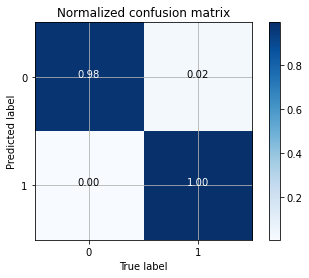

In [27]:
from sklearn.metrics import confusion_matrix
import itertools

model.eval()
with torch.no_grad():
    outputs = model(test_images)
    _, predicted_labels = torch.max(outputs.data, 1)
    cm = confusion_matrix(test_labels.to("cpu"), predicted_labels.to("cpu"))
    print('Confusion matrix:\n', cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')